Importing the stuff we need

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import nltk

2023-12-13 16:39:16.715986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 16:39:16.716018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 16:39:16.716037: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 16:39:16.720033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
EXPERIMENT_NAME = "all-books-with-text"

In [3]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/sgzmd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Defining some constants

In [4]:
# Constants
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 128

Let's read and pre-process the data

In [5]:
df = pd.read_csv("../data/full-long-list.csv")  # Load the CSV file into a pandas DataFrame

# drop all non-string records, unclear where they are coming from
df = df[df.apply(lambda row: isinstance(row['Body'], str) and isinstance(row['Genres'], str), axis=1)]

def is_sf_genre(genre: str) -> bool:
    return genre.startswith('sf') or genre == 'popadanec' or genre == 'litrpg'

# define is_sf label
df['is_sf'] = df['Genres'].apply(lambda genres: any(is_sf_genre(genre) for genre in genres.split(';')))
df.head()

,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf
0,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_fantasy_city;det_action;popadanec;magician_...,Извращенный отшельник;Илья Романов,Наемник «S» ранга,sf_fantasy_city\n det_action\n popadanec\n...,"\n Прожив пять веков в шкуре вампира, я оты...",729588.fb2,0,True
1,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,fanfiction;magician_book;popadanec;network_lit...,Cyberdawn,Лишний свиток,fanfiction\n magician_book\n popadanec\n ...,"\n Попаданец в черножопого, ехидного, своло...",729587.fb2,0,True
2,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,religion_orthodoxy;religion_christianity;relig...,Коллектив авторов,Святитель Василий Великий,religion_orthodoxy\n religion_christianity\n...,NaN,729595.fb2,0,False
3,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_heroic;sf_humor;sf_social,Андрей Немиров,Квестер,sf_heroic\n sf_humor\n sf_social\n \n ...,"\n Доброго времени суток, читатель! По слов...",729601.fb2,0,True
4,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,sf_horror;literature_19;literature_20;sf_horro...,Джеймс Брандер Мэтьюз;Артур Грей;Эдмунд Митчел...,Мистические истории. Фантом озера,sf_horrorliterature_19literature_20sf_horrorfo...,NaN,729599.fb2,0,True


Let's define synthetic column that we'll be doing the actual classification on

In [6]:
# remove all rows which do not have annotation
df = df[df['Annotation'].str.len() >= 20]

# Create 'body' field by concatenating 'Annotation', 'Authors', 'Genres', and 'BookTitle'
df['body'] = df['Annotation'] + ' ' + df['Authors'] + ' ' + df['Genres'] + ' ' + df['BookTitle'] + ' ' + df['Body']
df.sample(10)

,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf,body
163763,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,dramaturgy;children;child_tale,Дмитрий Чарков,Рума. Сказка о новогодней мечте,dramaturgychildrenchild_taleДмитрийЧарков0d1d2...,У всех есть мечта. И у маленьких-маленьких щен...,664975.fb2,0,False,У всех есть мечта. И у маленьких-маленьких щен...
106185,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_action;sf_space,Елена Горелик,Бортовой,sf_action\n sf_space\n \n Елена\n Го...,\n Новейший научно-исследовательский корабл...,512773.fb2,0,True,\n Новейший научно-исследовательский корабл...
73441,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_fantasy;love_sf,Эбигейл Гиббс,Тени школы Кейбл,sf_fantasy\n love_sf\n \n Эби...,"\n \n\tСогласно древнему пророчеству, д...",414904.fb2,0,True,"\n \n\tСогласно древнему пророчеству, д..."
46428,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sci_medicine;home_health,Юлия Николаева,"Ромашка, цикорий, имбирь в помощь организму",sci_medicine\n home_health\n \n Юлия\n ...,"\n Ромашка, цикорий и имбирь — природные це...",321116.fb2,0,False,"\n Ромашка, цикорий и имбирь — природные це..."
190124,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_fantasy,Анна Мездрина,Притворись моим демоном,love_fantasy АннаМездринаbeb1834f-e659-11ed-87...,"Восемь лет Кириана пытается вспомнить, что про...",729322.fb2,0,False,"Восемь лет Кириана пытается вспомнить, что про..."
144928,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf-history,Павел Виноградов,Четвертый кодекс,﻿\n\n \n \n sf-history\n \n ...,\n Космическая катастрофа пробила во вр...,615632.fb2,0,True,\n Космическая катастрофа пробила во вр...
7802,/pool1/share/Downloads/Flibusta-Patch/f.fb2-75...,sf_horror;sf_horror,Михаил Тульский,Игрушка в наследство,sf_horror\n sf_horror\n \n Михаил\n ...,\n Разбирая коробку с игрушками на чердаке ...,750766.fb2,0,True,\n Разбирая коробку с игрушками на чердаке ...
39838,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf,Александр Колпаков,Последний лемур,sf\n \n Александр\nЛаврентьевич\n Колп...,\n У побережья Мадагаскара обнаруживаю чере...,297032.fb2,0,True,\n У побережья Мадагаскара обнаруживаю чере...
234259,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf;child_sf,Роберт Хайнлайн,Будет скафандр – будут и путешествия,sf\nchild_sf\n\nРоберт\nЭнсон\nХайнлайн\n\nБуд...,"\nЗамечательный, добрый и динамичный роман мас...",136940.fb2,0,True,"\nЗамечательный, добрый и динамичный роман мас..."
65005,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_space;sf_action,Владимир Поселягин,Освободившийся,sf_space\n sf_action\n \n Владимир\n ...,\n Миры Содружества (Вселенная EVE-online)....,385356.fb2,0,True,\n Миры Содружества (Вселенная EVE-online)....


In [7]:
# Filter the dataframe based on the conditions
df_selected_1 = df[(df['IsSelected'] == 1)]
df_selected_0 = df[(df['IsSelected'] == 0) & (~df['is_sf'])]

# -1 are manually selected negative samples
df_selected_neg = df[(df['IsSelected'] == -1)]

# Sample the same number of records where selected = 0
df_selected_0_sampled = df_selected_0.sample(n=len(df_selected_1), random_state=42)

negative_samples = pd.concat([df_selected_0_sampled, df_selected_neg])

# Set 'selected' to 0 for all negative_samples
negative_samples['IsSelected'] = 0

# Concatenate the two dataframes
new_df = pd.concat([df_selected_1, negative_samples])

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

# Print the new dataframe
new_df.sample(10)


,ID,Genres,Authors,BookTitle,Body,Annotation,FileName,IsSelected,is_sf,body
986,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,prose_military,Макс Кранихфельд,Песня Северного Ветра,prose_military\n \n Макс\n Кранихфельд...,\n Эхо кавказской войны в мирной жизни…\n,177999.fb2,0,False,\n Эхо кавказской войны в мирной жизни…\n ...
1362,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_contemporary;love_detective;network_liter...,Anne Dar,Один год жизни (СИ),love_contemporary\n love_detective\n netwo...,\n Глория Пейдж всю жизнь стремилась вырват...,539736.fb2,0,False,\n Глория Пейдж всю жизнь стремилась вырват...
1369,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,prose_classic,Оноре Бальзак,"Шуаны, или Бретань в 1799 году","prose_classic\n\nОноре\nде\nБальзак\n\nШуаны, ...",\nДействие «Шуанов» происходит в конце 1799 го...,193408.fb2,0,False,\nДействие «Шуанов» происходит в конце 1799 го...
1145,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_short,Полина Наумова,Дорога в жизнь,love_shortПолинаНаумоваd11f53e7-ca84-4a98-8460...,"Сборник коротких рассказов, написанных в рамка...",675796.fb2,0,False,"Сборник коротких рассказов, написанных в рамка..."
10,/pool1/share/Downloads/Flibusta-Patch/f.fb2-72...,network_literature;sf_action,Дан Лебэл,Купол,network_literature\n sf_action\n \n Дан...,\n На планету Земля пришло Схождение. Велич...,732211.fb2,1,True,\n На планету Земля пришло Схождение. Велич...
323,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,sf_heroic;fantasy_fight;popadanec,Александра Лисина,Последняя партия,sf_heroicfantasy_fightpopadanec АлександраЛиси...,«Последняя партия» – фантастический роман Алек...,591023.fb2,1,True,«Последняя партия» – фантастический роман Алек...
903,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_contemporary,Злата Романова;Яна Невинная,После развода. Вернуть жену,love_contemporary\n \n Злата\n Романов...,\n — Не смей называть моего сына отродьем!\...,650273.fb2,0,False,\n — Не смей называть моего сына отродьем!\...
532,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,popadancy;sf_action,Жорж Бор,Синдикат. Объединение,popadancy\n sf_action\n \n Жорж\n Бо...,\n Настало время совершить новый рывок и об...,672097.fb2,1,True,\n Настало время совершить новый рывок и об...
889,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,det_action;det_political,Виталий Донцов,Интерполицейский,det_action\n det_political\n \n Виталий...,"\n Террор не знает пределов, не имеет веры ...",553825.fb2,0,False,"\n Террор не знает пределов, не имеет веры ..."
899,/pool1/share/Flibusta/fb2.Flibusta.Net/archive...,love_sf,Ксюра Невестина,Огненная дева для ледяного дракона,love_sf\n \n Ксюра\n Невестина\n htt...,"\n Бывший выкинул меня из окна, а очнулась ...",666049.fb2,0,False,"\n Бывший выкинул меня из окна, а очнулась ..."


Defining tokenizer and some helper methods

In [8]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Function to segment and tokenize text
def segment_and_tokenize(text):
    # Split text into sentences
    sentences = sent_tokenize(text, language='russian')
    tokenized_output = []
    attention_mask_output = []

    for sentence in sentences:
        # Tokenize each sentence
        tokens = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=MAX_TOKENS, 
                                       truncation=True, padding='max_length', return_tensors='tf')
        tokenized_output.append(tokens['input_ids'])
        attention_mask_output.append(tokens['attention_mask'])

        # Check if we've reached the maximum number of tokens
        if sum([len(t[0]) for t in tokenized_output]) >= MAX_TOKENS:
            break

    # Combine tokenized sentences up to the maximum length
    input_ids = tf.concat(tokenized_output, axis=1)[0,:MAX_TOKENS]
    attention_mask = tf.concat(attention_mask_output, axis=1)[0,:MAX_TOKENS]

    return input_ids, attention_mask

Let's run the tokenization and segmentation of the data

In [9]:
# Apply the function to the dataset
new_df['segmented_data'] = new_df['body'].apply(segment_and_tokenize)
new_df[['tokens', 'attention_mask']] = pd.DataFrame(new_df['segmented_data'].tolist(), index=new_df.index)

2023-12-13 16:39:45.591619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 16:39:45.594677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 16:39:45.594701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 16:39:45.595989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-13 16:39:45.596018: I tensorflow/compile

Now let's prepare and split the dataset

In [10]:
# Prepare dataset
X_ids = np.array(new_df['tokens'].tolist())
X_mask = np.array(new_df['attention_mask'].tolist())

y = new_df['is_sf'].values
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(X_ids, X_mask, y.astype('int32'), test_size=0.4)


Let's load the model now and define how we are fine-tuning it

In [11]:
from tensorflow.keras.layers import Dropout
bert = TFAutoModel.from_pretrained(MODEL_NAME, from_pt=True)
input_ids = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='input_ids')
input_mask = Input(shape=(MAX_TOKENS,), dtype=tf.int32, name='attention_mask')

embeddings = bert(input_ids, attention_mask=input_mask)[0]
pooled = GlobalMaxPool1D()(embeddings)

output = Dropout(0.2)(pooled)  # Add dropout layer with a dropout rate of 0.2
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=[input_ids, input_mask], outputs=output)

output = Dense(1, activation='sigmoid')(pooled)

model = Model(inputs=[input_ids, input_mask], outputs=output)

2023-12-13 16:39:49.661651: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a 

In [12]:
from tensorflow.keras.metrics import Precision, Recall
model.compile(optimizer=Adam(learning_rate=3e-5), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [13]:

history = model.fit([X_train_ids, X_train_mask], y_train, batch_size=16, epochs=4, validation_split=0.2)

Epoch 1/4


2023-12-13 16:40:05.682347: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbe205d70f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 16:40:05.682370: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-12-13 16:40:05.685531: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-13 16:40:05.783617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-13 16:40:05.820436: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 [==============================] - 35s 358ms/step - loss: 0.6236 - accuracy: 0.6710 - precision: 0.6730 - recall: 0.6331 - val_loss: 0.4686 - val_accuracy: 0.7701 - val_precision: 0.7340 - val_recall: 0.8214
Epoch 2/4
44/44 [==============================] - 15s 332ms/step - loss: 0.2899 - accuracy: 0.8860 - precision: 0.8732 - recall: 0.8964 - val_loss: 0.4419 - val_accuracy: 0.7931 - val_precision: 0.7400 - val_recall: 0.8810
Epoch 3/4
44/44 [==============================] - 15s 331ms/step - loss: 0.1305 - accuracy: 0.9654 - precision: 0.9618 - recall: 0.9675 - val_loss: 0.3803 - val_accuracy: 0.8563 - val_precision: 0.8391 - val_recall: 0.8690
Epoch 4/4
44/44 [==============================] - 15s 332ms/step - loss: 0.0449 - accuracy: 0.9856 - precision: 0.9852 - recall: 0.9852 - val_loss: 0.5060 - val_accuracy: 0.8218 - val_precision: 0.7912 - val_recall: 0.8571


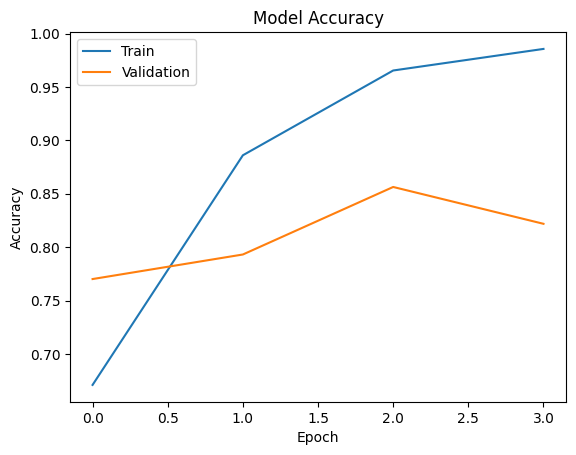

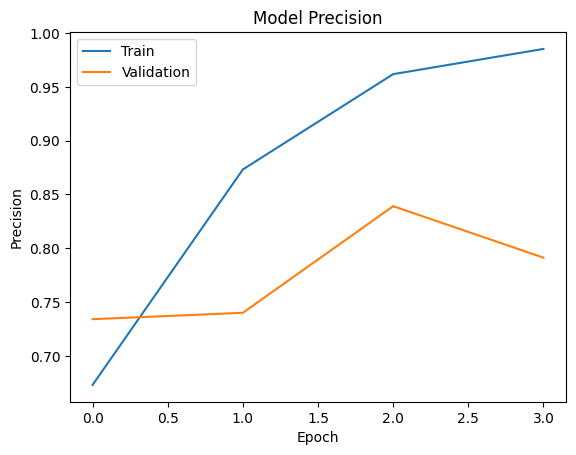

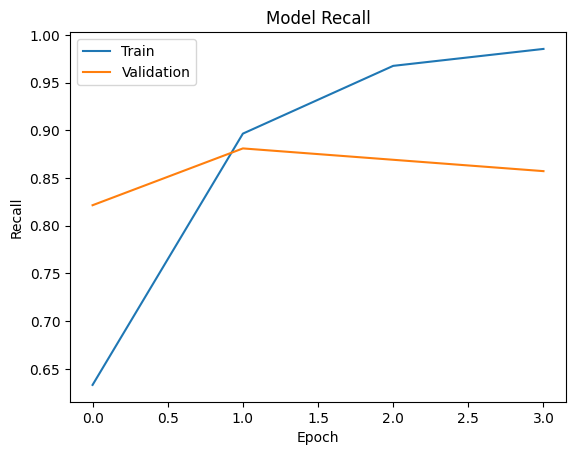

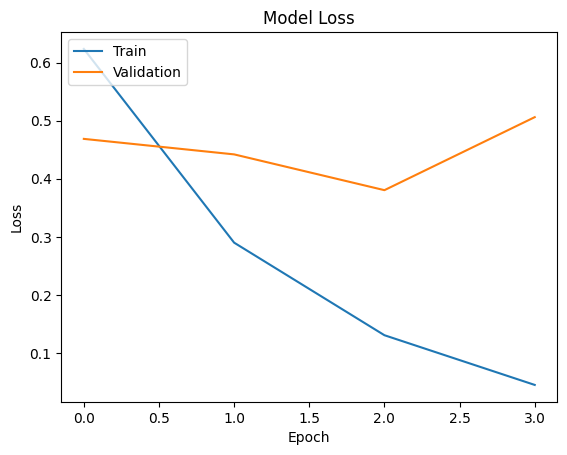

In [14]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the model.fit() method in TensorFlow

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [15]:
model.evaluate([X_test_ids, X_test_mask], y_test)

19/19 [==============================] - 3s 183ms/step - loss: 0.4579 - accuracy: 0.8495 - precision: 0.8279 - recall: 0.8824


[0.4578762352466583,
 0.8494809865951538,
 0.8279221057891846,
 0.8823529481887817]

Let's take a quick look at false positives

In [16]:
predictions = model.predict([X_test_ids, X_test_mask])
predicted_labels = (predictions > 0.5).astype('int32')
false_positives = np.where((predicted_labels == 1) & (y_test == 0))[0]

for index in false_positives[:10]:  # Top 10 false positives
    print(f"Index: {index}, Prediction: {predictions[index]}, Actual: {y_test[index]}")

19/19 [==============================] - 5s 179ms/step
Index: 0, Prediction: [0.7567328], Actual: 0
Index: 0, Prediction: [0.7567328], Actual: 0
Index: 0, Prediction: [0.7567328], Actual: 0
Index: 0, Prediction: [0.7567328], Actual: 0
Index: 0, Prediction: [0.7567328], Actual: 0
Index: 0, Prediction: [0.7567328], Actual: 0
Index: 0, Prediction: [0.7567328], Actual: 0
Index: 0, Prediction: [0.7567328], Actual: 0
Index: 0, Prediction: [0.7567328], Actual: 0
Index: 0, Prediction: [0.7567328], Actual: 0


In [17]:
import tensorflow
from tensorflow.keras.models import save_model

model.save_weights(f'../data/experiments/${EXPERIMENT_NAME}/checkpoints/segmented-selected')
save_model(model, f'../data/experiments/${EXPERIMENT_NAME}/model.h5')

/tmp/ipykernel_48763/2424261846.py:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, f'../data/experiments/${EXPERIMENT_NAME}/model.h5')


In [18]:
df_sf = df[(df['IsSelected'] == 0) & df['is_sf']]
df_sf = df_sf.dropna(subset=['body'])

df_sf['segmented_data'] = df_sf['body'].apply(segment_and_tokenize)
df_sf[['tokens', 'attention_mask']] = pd.DataFrame(df_sf['segmented_data'].tolist(), index=df_sf.index)

inference_X_ids = np.array(df_sf['tokens'].tolist())
inference_X_mask = np.array(df_sf['attention_mask'].tolist())


# Make predictions
predictions = model.predict([inference_X_ids, inference_X_mask])

# Get the top 100 results
top_1000_results = df_sf.iloc[predictions.argsort(axis=0)[-1000:].flatten()]
top_1000_results.to_csv(f'../data/experiments/${EXPERIMENT_NAME}/top_1000_results.csv', index=True)

In [ ]:
top_1000_results['FileName'].to_csv(f'../data/experiments/${EXPERIMENT_NAME}/top_1000_small_matched.txt', index=False, header=False)
SQL = """
DROP TABLE IF EXISTS DetectedBooks;

CREATE TABLE DetectedBooks (
    BookId INT NOT NULL,
    FileName VARCHAR(255) NOT NULL,
    Annotation VARCHAR(4096) NOT NULL,
    BookTitle VARCHAR(1024) NOT NULL,
    Authors VARCHAR(1024) NOT NULL,
    Genres VARCHAR(1024) NOT NULL
);


"""

def E(text):
    # Escaping single quotes
    text = text.replace("'", "\\'")
    # Escaping double quotes
    text = text.replace('"', '\\"')
    return text

for i, row in top_1000_results.iterrows():
  bookId = row['FileName'][:-4]
  SQL += "INSERT INTO DetectedBooks (BookId, FileName, Annotation, BookTitle, Authors, Genres) VALUES "
  SQL += f"({bookId}, '{row['FileName']}', '{E(row['Annotation'])}', '{E(row['BookTitle'])}', '{E(row['Authors'])}', '{row['Genres']}');\n"

SQL = SQL[:-2] + ';'
f = open(f'../data/experiments/${EXPERIMENT_NAME}/detected.sql', 'w')
f.write(SQL)

615188

In [ ]:
import mysql.connector
import db_config

# Connect to MySQL
cnx = mysql.connector.connect(
  host=db_config.DB_HOST,
  port=db_config.DB_PORT,
  user=db_config.DB_USER,
  password=db_config.DB_PASSWORD,
  database=db_config.DB_DATABASE,
)

cursor = cnx.cursor()
cursor.execute(SQL)